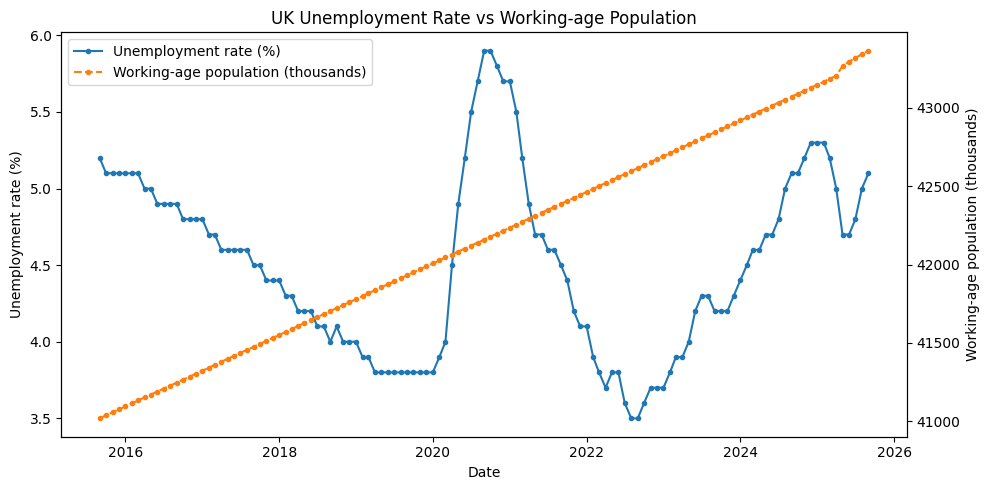

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# =========================
# 1. 读取数据
# =========================
unemployment = pd.read_csv(
    "using_data_csv/失业率（15-25）.csv",
    parse_dates=["date"]
)

working_age_pop = pd.read_csv(
    "using_data_csv/劳动人口数量（15-25）.csv",
    parse_dates=["date"]
)

# =========================
# 2. 合并数据
# =========================
df = pd.merge(
    unemployment,
    working_age_pop,
    on="date",
    how="inner"
).sort_values("date")

# =========================
# 3. 双轴折线图（坐标轴黑色）
# =========================
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左轴：失业率（蓝色实线 + 点）
line1 = ax1.plot(
    df["date"],
    df["rate"],
    color="tab:blue",
    linestyle="-",
    marker="o",
    markersize=3,
    label="Unemployment rate (%)"
)
ax1.set_ylabel("Unemployment rate (%)")
ax1.set_xlabel("Date")

# 右轴：劳动年龄人口（橙色虚线 + 点）
ax2 = ax1.twinx()
line2 = ax2.plot(
    df["date"],
    df["value"],
    color="tab:orange",
    linestyle="--",
    marker="o",
    markersize=3,
    label="Working-age population (thousands)"
)
ax2.set_ylabel("Working-age population (thousands)")

# 合并图例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

# 标题
plt.title("UK Unemployment Rate vs Working-age Population")

plt.tight_layout()

# 创建 pic 文件夹（若不存在）
os.makedirs("pic", exist_ok=True)

# 保存图片
plt.savefig(
    "pic/uk_unemployment_vs_working_age_population.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [2]:
import pandas as pd
import numpy as np

# ===== 1) 读取你给的缺失版 CSV =====
in_path = r"using_data_csv/招聘指数（缺失）.csv"
df = pd.read_csv(in_path)

# 兼容列名：你之前用过 date/value 或 data/value
date_col = "date" if "date" in df.columns else ("data" if "data" in df.columns else None)
value_col = "value" if "value" in df.columns else None
if date_col is None or value_col is None:
    raise ValueError(f"CSV 列名不对：需要包含 date(or data) 和 value。当前列：{df.columns.tolist()}")

df = df[[date_col, value_col]].rename(columns={date_col: "date", value_col: "value"})

# ===== 2) 规范成月度时间序列（每月1号）=====
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").drop_duplicates("date")
df["value"] = pd.to_numeric(df["value"], errors="coerce")

# 补出完整月度索引（从最早到 2025-09-01）
end_date = pd.Timestamp("2025-09-01")
full_idx = pd.date_range(df["date"].min(), end_date, freq="MS")  # MS = Month Start
ts = df.set_index("date")["value"].reindex(full_idx)

# ===== 3) 用“过去趋势”外推缺失到 2025-09 =====
# 优先：Holt 线性趋势（更像“沿着趋势走”）；如果 statsmodels 没装，就退回线性回归外推
def fill_with_trend(series: pd.Series) -> pd.Series:
    # series: 月度索引（MS），可能中间缺失
    s = series.copy()

    # 只用历史已观测值拟合
    y = s.dropna()
    if len(y) < 6:
        raise ValueError("可用于拟合的历史数据太少（至少建议 >= 6 个月）。")

    last_obs_date = y.index.max()
    if last_obs_date >= s.index.max():
        return s  # 已经完整

    # 需要预测多少期
    steps = (s.index.max().to_period("M") - last_obs_date.to_period("M")).n
    future_idx = pd.date_range(last_obs_date + pd.offsets.MonthBegin(1), s.index.max(), freq="MS")

    # --- 方法A：Holt (statsmodels) ---
    try:
        from statsmodels.tsa.holtwinters import Holt

        model = Holt(y, initialization_method="estimated")
        fit = model.fit(optimized=True)
        fcst = pd.Series(fit.forecast(steps), index=future_idx)

    except Exception:
        # --- 方法B：线性趋势回归（稳妥兜底） ---
        # 用时间序号做自变量
        x = np.arange(len(y), dtype=float)
        coef = np.polyfit(x, y.values.astype(float), deg=1)  # 线性趋势
        x_future = np.arange(len(y), len(y) + steps, dtype=float)
        fcst = pd.Series(np.polyval(coef, x_future), index=future_idx)

    # 不让预测出现负数（指数类数据一般不应为负）
    fcst = fcst.clip(lower=0)

    # 填回原序列
    s.loc[future_idx] = fcst.values
    return s

ts_filled = fill_with_trend(ts)

# ===== 4) 输出为 CSV（两列：date, value）=====
out_df = ts_filled.reset_index()
out_df.columns = ["date", "value"]
out_df["date"] = out_df["date"].dt.strftime("%Y-%m-%d")
out_df["value"] = out_df["value"].round(2)

out_path = r"using_data_csv/招聘指数_补全至2025-09.csv"
out_df.to_csv(out_path, index=False, encoding="utf-8-sig")

print("已输出：", out_path)
print(out_df.tail(15))


已输出： using_data_csv/招聘指数_补全至2025-09.csv
          date  value
65  2024-07-01  87.18
66  2024-08-01  87.05
67  2024-09-01  87.01
68  2024-10-01  87.93
69  2024-11-01  88.85
70  2024-12-01  89.77
71  2025-01-01  90.69
72  2025-02-01  91.61
73  2025-03-01  92.53
74  2025-04-01  93.45
75  2025-05-01  94.37
76  2025-06-01  95.29
77  2025-07-01  96.21
78  2025-08-01  97.13
79  2025-09-01  98.05


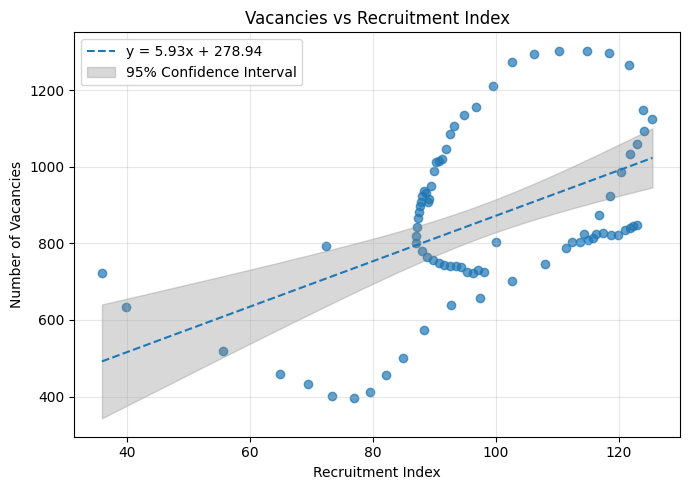

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# -----------------------------
# 1. 读取数据
# -----------------------------
vacancies = pd.read_csv(
    "using_data_csv/职位空缺.csv",
    parse_dates=["date"]
)

job_index = pd.read_csv(
    "using_data_csv/招聘指数_补全至2025-09.csv",
    parse_dates=["date"]
)


vacancies = vacancies.rename(columns={"value": "vacancies"})
job_index = job_index.rename(columns={"value": "job_index"})

# -----------------------------
# 2. 按日期合并
# -----------------------------
df = pd.merge(vacancies, job_index, on="date", how="inner")

x = df["job_index"].values
y = df["vacancies"].values
n = len(x)

# -----------------------------
# 3. 线性回归
# -----------------------------
slope, intercept = np.polyfit(x, y, 1)

x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

# -----------------------------
# 4. 计算 95% 置信区间
# -----------------------------
# 预测值
y_pred = slope * x + intercept

# 残差标准误
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))

# t 值
t_val = stats.t.ppf(0.975, df=n - 2)

# 置信区间公式
x_mean = np.mean(x)
conf_interval = t_val * s_err * np.sqrt(
    1/n + (x_fit - x_mean)**2 / np.sum((x - x_mean)**2)
)

y_upper = y_fit + conf_interval
y_lower = y_fit - conf_interval

# -----------------------------
# 5. 绘图
# -----------------------------
plt.figure(figsize=(7, 5))

# 散点
plt.scatter(x, y, alpha=0.7)

# 回归线
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    label=f"y = {slope:.2f}x + {intercept:.2f}"
)

# 置信区间（灰色）
plt.fill_between(
    x_fit,
    y_lower,
    y_upper,
    color="grey",
    alpha=0.3,
    label="95% Confidence Interval"
)

plt.xlabel("Recruitment Index")
plt.ylabel("Number of Vacancies")
plt.title("Vacancies vs Recruitment Index")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 保存图片
plt.savefig(
    "pic/Vacancies vs Recruitment Index.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
